## 1. Setup & Libraries
Import necessary libraries for data analysis, visualization, preprocessing, and modeling.


In [33]:

# 1. Setup & Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)


## 2. Data Loading
Load the cleaned HR Employee Attrition dataset and inspect basic info, data types, and target distribution.


In [34]:

# 2. Data Loading

data_path = "../data/HR-Employee-Attrition_cleaned.csv"
df = pd.read_csv(data_path)

# Quick overview
print(df.head())
print(df.info())
print(df['Attrition'].value_counts())


   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeNumber  \
0                 1          2  Life Sciences               1   
1                 8          1  Life Sciences               2   
2                 2          2          Other               4   
3                 3          4  Life Sciences               5   
4                 2          1        Medical               7   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  \
0                        2  Female          94               3         2   
1           

## 3. Data Cleaning & Preprocessing
- Check for missing values and duplicates.  
- Encode the target variable `Attrition` (Yes → 1, No → 0).  
- Identify categorical and numerical features for preprocessing.

In [35]:
# 3. Data Cleaning & Preprocessing

# Check for missing values
print(df.isna().sum())

# Remove duplicates if any
df.drop_duplicates(inplace=True)

# Encode target variable
df['Attrition'] = df['Attrition'].map({'Yes':1, 'No':0})

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
numerical_cols.remove('Attrition')  # remove target from features


Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64


## 4. Exploratory Data Analysis (EDA)
- Visualize the distribution of the target variable.  
- Compare attrition across categorical features (e.g., OverTime).  
- Compute and plot correlation matrix to identify relationships between features.

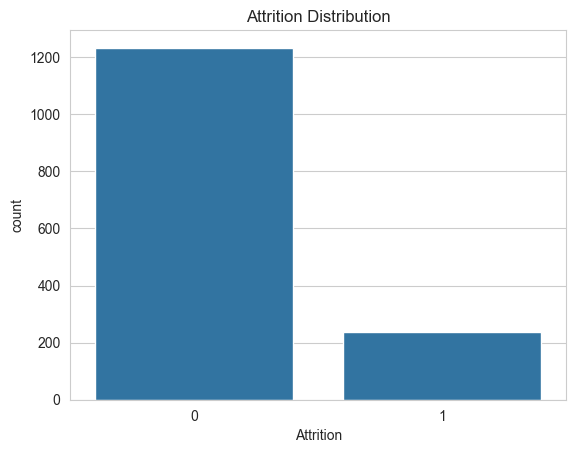

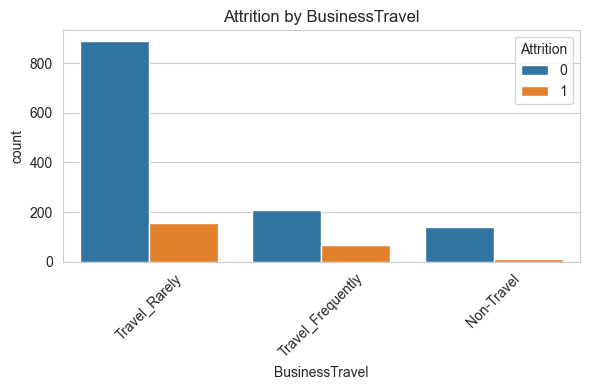

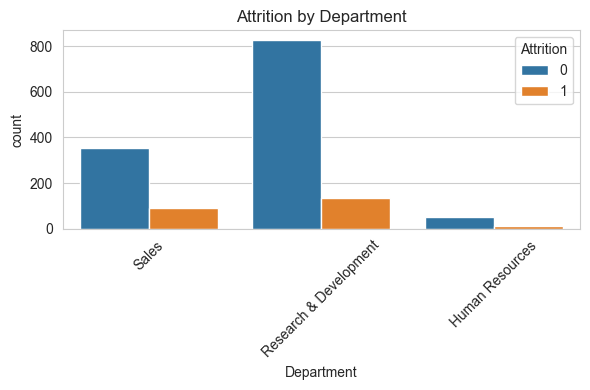

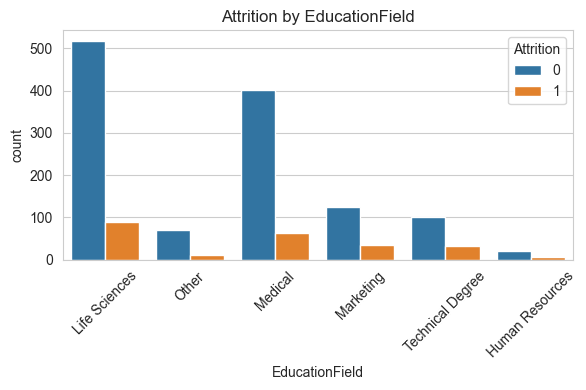

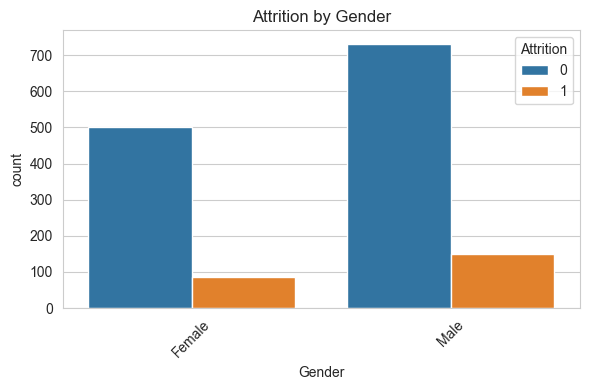

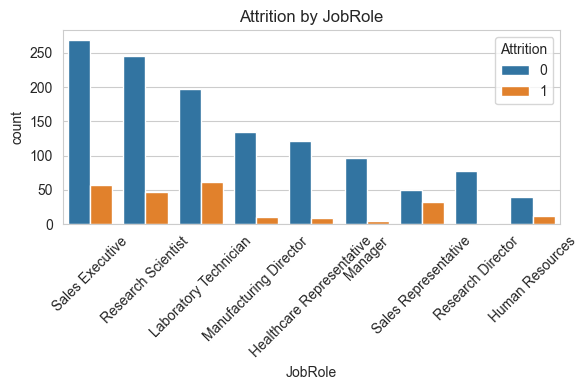

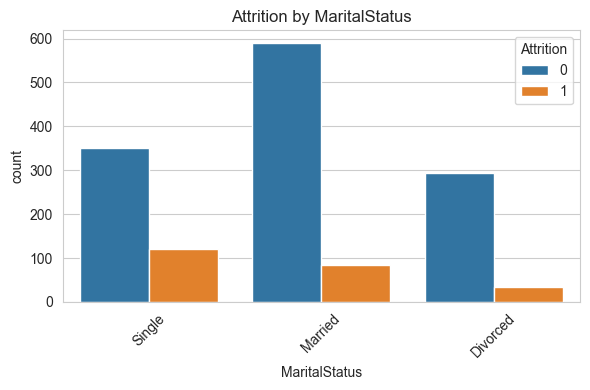

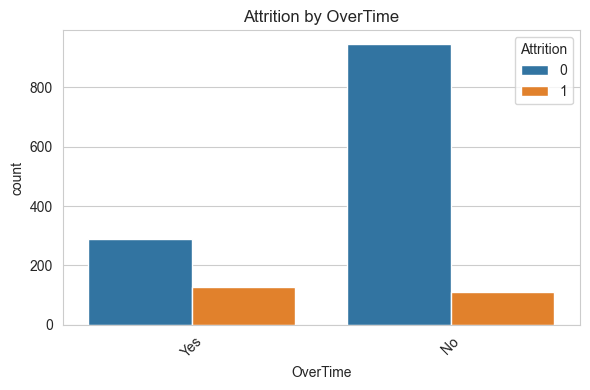

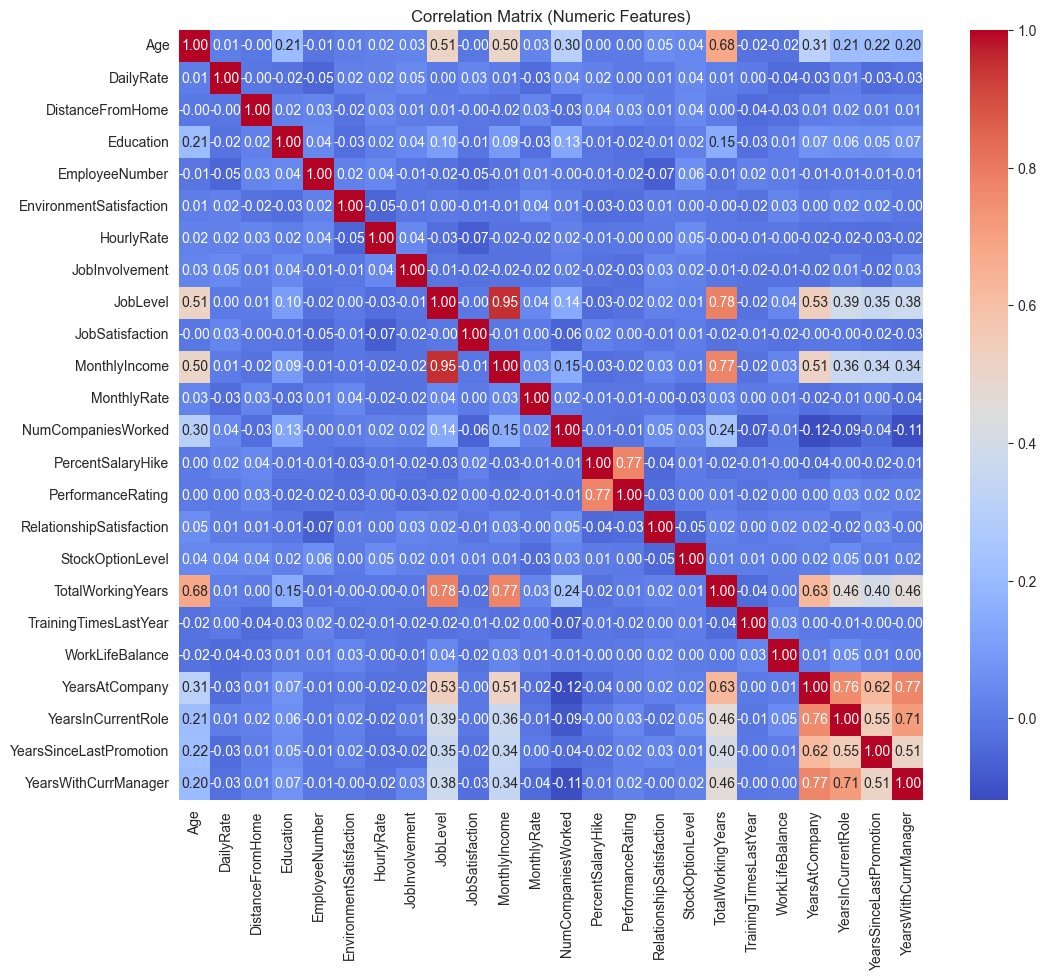

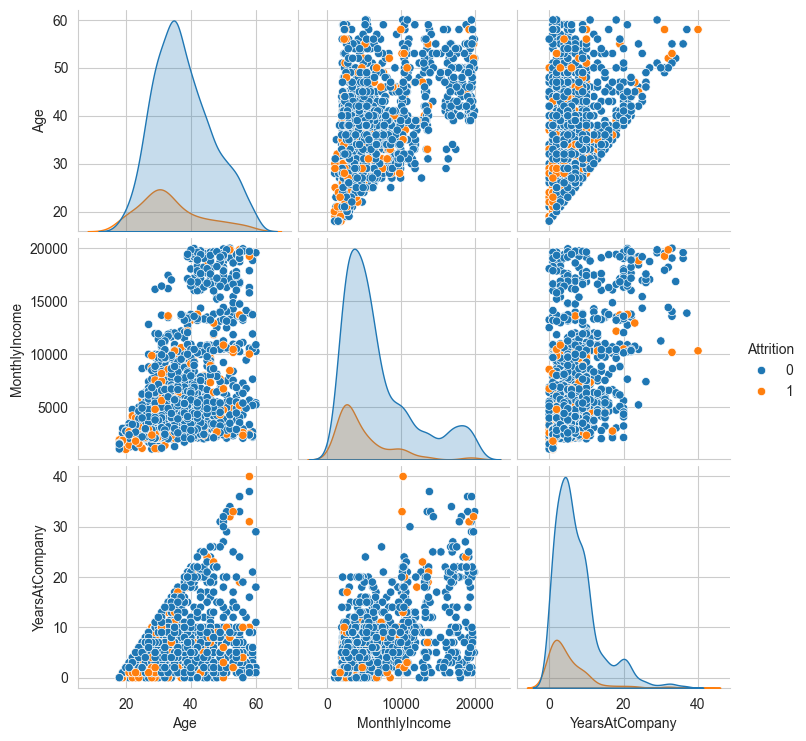

In [36]:
# 4. Exploratory Data Analysis (EDA)

# --- Target distribution ---
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Distribution')
plt.show()

# --- Attrition by categorical features ---
categorical_cols_no_target = [col for col in categorical_cols if col != 'Attrition']

for col in categorical_cols_no_target:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='Attrition', data=df)
    plt.title(f'Attrition by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- Correlation heatmap for numeric features ---
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols.remove('Attrition')  # target not needed here

plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix (Numeric Features)')
plt.show()

# --- Pairplot for selected numeric features ---
# Optional: visualize relationships
selected_features = ['Age','MonthlyIncome','YearsAtCompany']
sns.pairplot(df[selected_features + ['Attrition']], hue='Attrition')
plt.show()



## 5. Feature Engineering
- Example: High-risk employee profile based on `OverTime`, `JobSatisfaction`, and `YearsAtCompany`.  
- Optional: Additional features can be created based on domain knowledge.


In [37]:

# 5. Feature Engineering

# Example: Creating high risk feature
df['HighRiskProfile'] = ((df['OverTime']=='Yes') & 
                         (df['JobSatisfaction']<=2) & 
                         (df['YearsAtCompany']<3)).astype(int)



## 6. Modeling
- Split data into train and test sets (stratified by target).  
- Preprocess features: StandardScaler for numerical, OneHotEncoder for categorical.  
- Apply SMOTE to balance the training set.  
- Train models:
  - Logistic Regression
  - Random Forest  
- Evaluate using Accuracy, Precision, Recall, F1-score, and Confusion Matrix.


==== LogisticRegression ====
Accuracy: 0.7721088435374149
Precision: 0.3717948717948718
Recall: 0.6170212765957447
F1 Score: 0.464


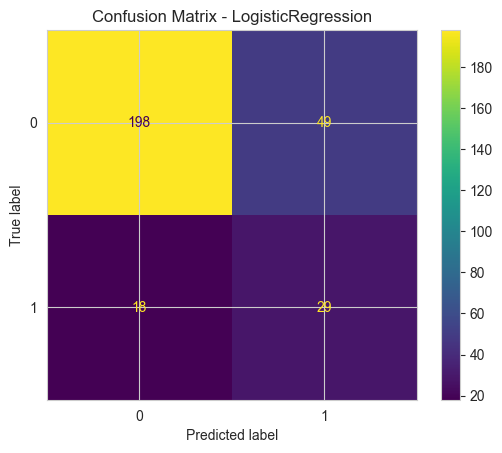

==== RandomForest ====
Accuracy: 0.8673469387755102
Precision: 0.7
Recall: 0.2978723404255319
F1 Score: 0.417910447761194


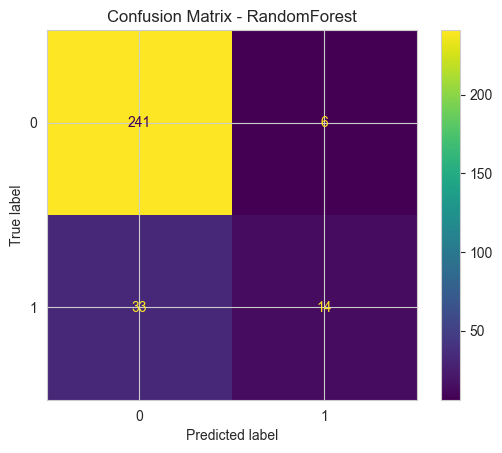

In [38]:

# 6. Modeling

X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Apply SMOTE to balance classes
X_train_enc = preprocessor.fit_transform(X_train)
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_enc, y_train)

X_test_enc = preprocessor.transform(X_test)

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test_enc)
    print(f"==== {name} ====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix - {name}')
    plt.show()



**Notes for Reviewers / Collaborators:**
- The workflow is modular and reproducible.
- SMOTE is applied only on the training set to prevent data leakage.
- Preprocessing pipeline ensures categorical variables are correctly handled for future predictions.
- Visualization sections can be expanded depending on stakeholder needs.
